## xcube Data Store Framework – Climate Data Store

This notebook demonstrates how to access [Climate Data Store](https://cds.climate.copernicus.eu) (CDS) data via the dedicated xcube store, which provides dynamic data cube views into each gridded data set.

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2023

-----------------

**This notebook runs with the python environment `deepesdl-xcube-1.1.2`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

**Please note:** 
    
To access data from the Climate Data Store, you need a CDS API key. 

For DeepESDL default credentials are configured, but due to bandwith limitation by CDS they might not be performant when used by several people simultaneously.

You can obtain the UID and API key as follows:

1. Create a user account on the [CDS Website](https://cds.climate.copernicus.eu/user/register).
2. Log in to the website with your user name and password.
3. Navigate to your user profile on the website. Your API key is shown at the bottom of the page.

Then export the `CDSAPI_URL` and `CDSAPI_KEY` environment variables, replacing `[UID]` and `[API-KEY]` with the actual values from your account:

```bash
export CDSAPI_URL=https://cds.climate.copernicus.eu/api/v2
export CDSAPI_KEY=[UID]:[API-KEY]
```

You can also set the variables directly in this Notebook. (However, we do not recommend this since this introduces a security risk!)

In [1]:
# import os
# os.environ['CDSAPI_URL'] = 'https://cds.climate.copernicus.eu/api/v2'
# os.environ['CDSAPI_KEY'] = '[UID]:[API-KEY]'

In [2]:
# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
from IPython.display import JSON
import matplotlib as mpl
import matplotlib.pyplot as plt

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12

Check whether the `cds` store is among the available stores, if not please follow the installation information from the top of this notebook. 

In [4]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Usually we need more information to get the actual data store object. Which data store parameters are available for `cds`?

In [5]:
get_data_store_params_schema('cds')

Provide mandatory parameters to instantiate the store class:

In [6]:
store = new_data_store('cds')
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [7]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

Get more info about a specific dataset. This includes a description of the possible open formats:

In [8]:
store.describe_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis')

There are 4 required parameters, so we need to provide them to open a dataset:

In [9]:
dataset = store.open_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis', 
                          variable_names=['2m_temperature'], 
                          bbox=[-10, 45, 40, 65], 
                          spatial_res=0.25, 
                          time_range=['2001-01-01', '2010-12-31'])
dataset

xcube-cds version 0.9.2
2023-07-03 09:52:08,564 INFO Welcome to the CDS
2023-07-03 09:52:08,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-03 09:52:08,839 INFO Request is queued
2023-07-03 09:52:09,862 INFO Request is running
2023-07-03 09:52:58,282 INFO Request is completed
2023-07-03 09:52:58,283 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data6/adaptor.mars.internal-1688377964.2960339-29330-2-05a9c7d1-70d1-42ae-b868-7134d8158c11.nc to /tmp/tmpch8yuh31/tmpf5tgkuz9/data (3.7M)
2023-07-03 09:52:58,645 INFO Download rate 10.2M/s 


<xarray.Dataset>
Dimensions:  (lon: 200, lat: 80, time: 120)
Coordinates:
  * lon      (lon) float32 -9.875 -9.625 -9.375 -9.125 ... 39.38 39.62 39.88
  * lat      (lat) float32 64.88 64.62 64.38 64.12 ... 45.88 45.62 45.38 45.12
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2010-12-01
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-03 09:52:44 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

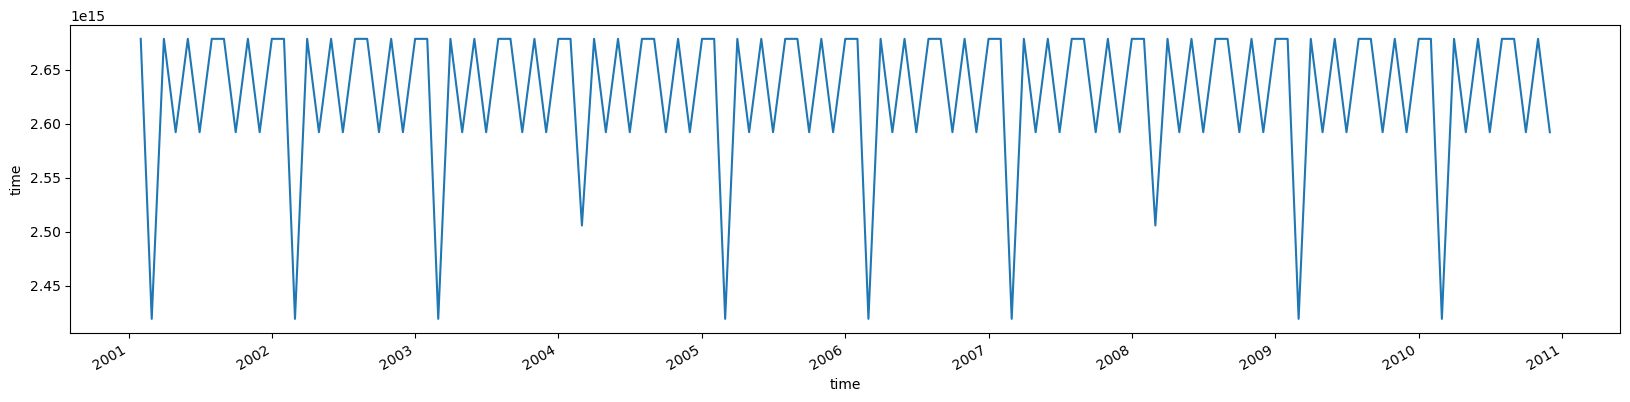

In [10]:
dataset.time.diff(dim='time').plot.line(figsize=(20, 4))

We can explore these data by plotting a temperature map for selected time points. First, we select January 2001. Land areas – and mountain ranges in particular – show up on the map as colder regions.

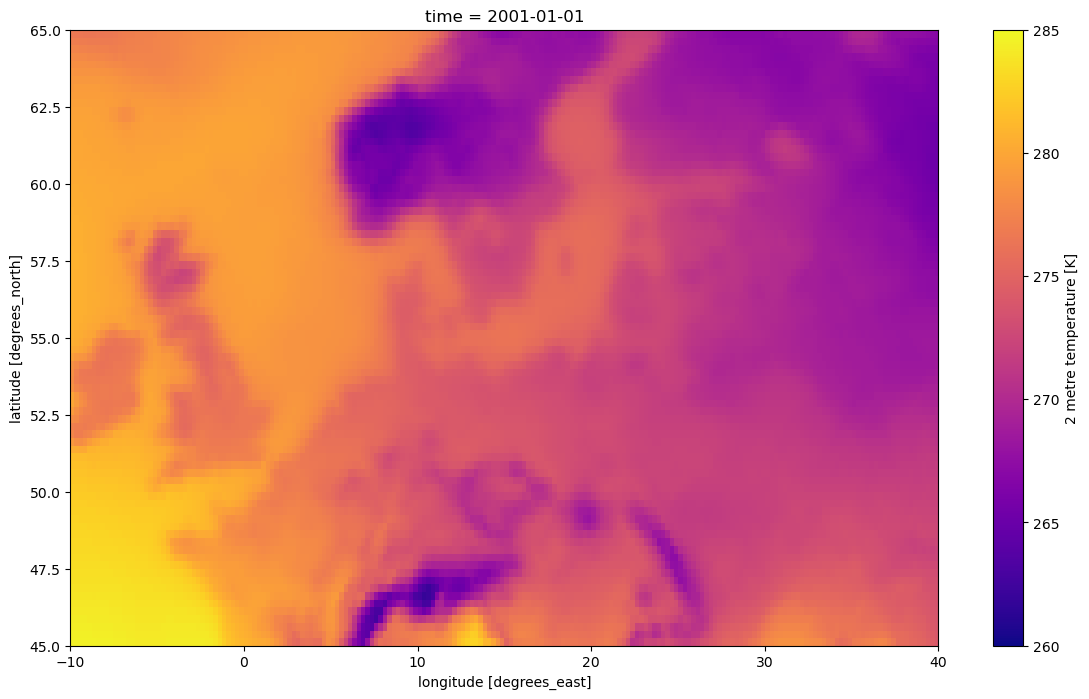

In [11]:
t2m_2001_jan = dataset.t2m.sel(time='2001-01-01 00:00:00', method='nearest')
t2m_2001_jan.plot.imshow(vmin=260, vmax=285, figsize=(14, 8), cmap='plasma')

For a more elegant and informative map, we define a function to plot a customized orthographic projection with overlaid coastlines and a grid.
